In [104]:
import pandas as pd
import numpy as np
import os
from datetime import datetime


In [105]:
# Get the current date and time. 
now = datetime.now()
now

datetime.datetime(2025, 3, 13, 11, 47, 20, 454121)

In [106]:
exercise_path = '../Python/Exercise Files/Pandas Course Resources/Pandas Course Resources/retail/'
transactions = pd.read_csv(os.path.join(exercise_path, "transactions.csv"), parse_dates=["date"])
transactions.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [107]:
# Create columns for year, month and day of the week
trans_df = (transactions.assign(
    year = transactions['date'].dt.year, 
    month = transactions["date"].dt.month,
    day_of_week = transactions["date"].dt.dayofweek,
    time_to_last_date = transactions["date"].max() -transactions["date"],
    date = transactions["date"].dt.strftime("%Y-%B-%d")
)
)

In [108]:
# True last date was 3 weeks later than we thought --> Three weeks after "2017-08-15". Add three weeks to time_to_last_date Column
trans_df.head()

(trans_df.assign(
    time_to_last_date = (trans_df["time_to_last_date"] + pd.to_timedelta(3, unit = "W")).dt.days,
    weeks_to_last_date = (lambda x: x["time_to_last_date"] / 7)
)
).head()

,date,store_nbr,transactions,year,month,day_of_week,time_to_last_date,weeks_to_last_date
0,2013-January-01,25,770,2013,1,1,1708,244.000000
1,2013-January-02,1,2111,2013,1,2,1707,243.857143
2,2013-January-02,2,2358,2013,1,2,1707,243.857143
3,2013-January-02,3,3487,2013,1,2,1707,243.857143
4,2013-January-02,4,1922,2013,1,2,1707,243.857143


In [109]:
# Oil Prices
oil = pd.read_csv(os.path.join(exercise_path, "oil.csv"), index_col="date", parse_dates=True)
oil = oil.rename(columns = {"dcoilwtico":"oil"})
oil.head()

,oil
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20


In [110]:
# What is the mean using forward fill, backward fill, and interpolation
# FF
mean = oil["oil"].mean().round(2)
ffill = oil["oil"].ffill().mean().round(2)
bfill = oil["oil"].bfill().mean().round(2)
interp = oil["oil"].interpolate().mean().round(2)

print(f"The differences are {mean}, {ffill}, {bfill}, {interp}")

# Funcationalize this


The differences are 67.71, 67.67, 67.67, 67.66


In [111]:
# Functionalized version
def calculate_means(df, column):
    """
    Calculate the mean, forward fill mean, backward fill mean, and interpolated mean for a given column in a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column (str): The name of the column to perform the calculations on.

    Returns:
    tuple: A tuple containing the mean, forward fill mean, backward fill mean, and interpolated mean.
    """
    mean = df[column].mean().round(2)
    ffill = df[column].ffill().mean().round(2)
    bfill = df[column].bfill().mean().round(2)
    interp = df[column].interpolate().mean().round(2)
    
    return mean, ffill, bfill, interp


mean, ffill, bfill, interp = calculate_means(oil, "oil")
print(f"The differences are {mean}, {ffill}, {bfill}, {interp}")


The differences are 67.71, 67.67, 67.67, 67.66


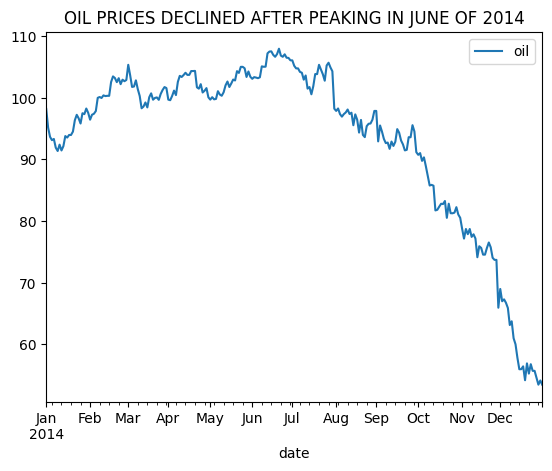

In [112]:
# Plot the series with forward fill for 2014
oil_2014 = oil["oil"].ffill().loc["2014"]
oil_2014.plot(title = "OIL PRICES DECLINED AFTER PEAKING IN JUNE OF 2014", legend = True);

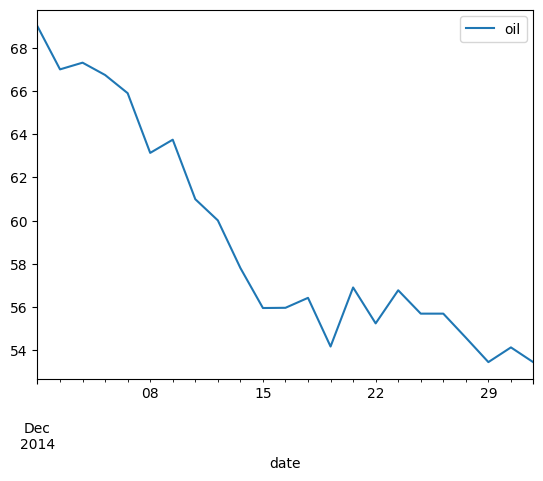

In [113]:
oil_2014.loc["2014-12"].plot(legend = True);

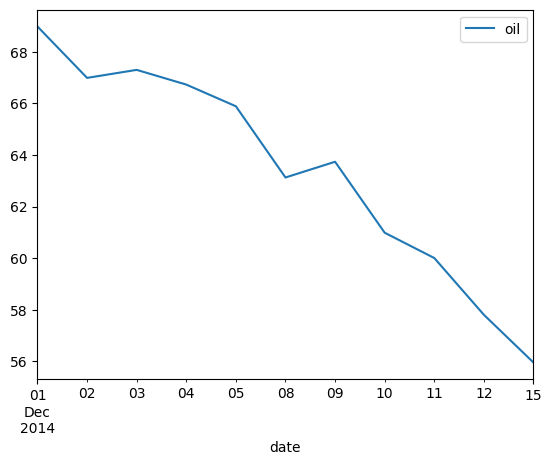

In [114]:
oil_2014.loc["2014-12-01":"2014-12-15"].plot(legend = True);

In [115]:
store_47_df = (trans_df[(trans_df["store_nbr"] == 47)]
 .groupby(["month", "year"])
 .agg({"transactions":"sum"})
 .reset_index()
 .sort_values(["year", "month"])
 )
store_47_df.head(24)

,month,year,transactions
0,1,2013,109668
5,2,2013,103706
10,3,2013,116873
15,4,2013,108571
20,5,2013,113532
25,6,2013,110637
30,7,2013,107506
35,8,2013,112001
40,9,2013,114468
44,10,2013,114585


<Axes: xlabel='month'>

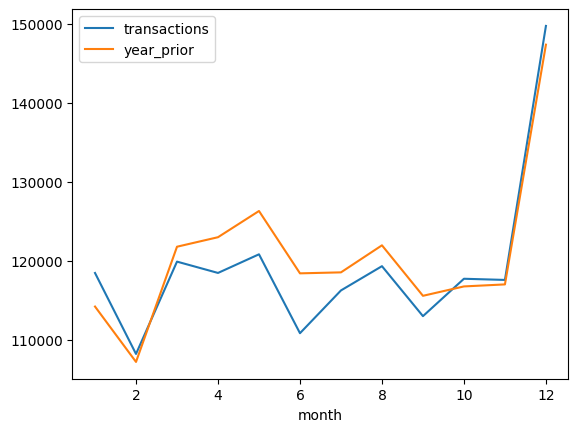

In [116]:
# Keep just the years 2014 - 2015, calculate 1 year lag
(store_47_df
    .assign(year_prior = store_47_df["transactions"].shift(12))
    .query("year in [2015]")
    .set_index("month")
    .drop(columns = "year")
    .plot())

In [119]:
# More efficient way of doing it?
# filter df to store 47, 'drop' store_nbr column via loc
transactions_47 = transactions.loc[trans_df["store_nbr"] == 47, ["date", "transactions"]]

## Calculate sum of sales by year and month
transactions_47 = (transactions_47
                   .groupby([transactions["date"].dt.year, transactions["date"].dt.month])
                   .sum())
#
## Calculate a 'year_prior' column by shiftly monthly sales series forward by 12 rows (months)
transactions_47["year_prior"] = transactions_47["transactions"].shift(12)
#
## Filter to 2015 and plot
transactions_47.loc[2015].plot();

TypeError: datetime64 type does not support sum operations

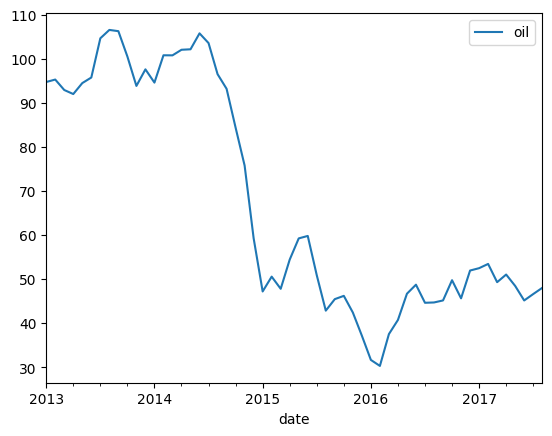

In [126]:
# Average oil priceby month and year
oil.resample("ME").mean().plot(legend = True);

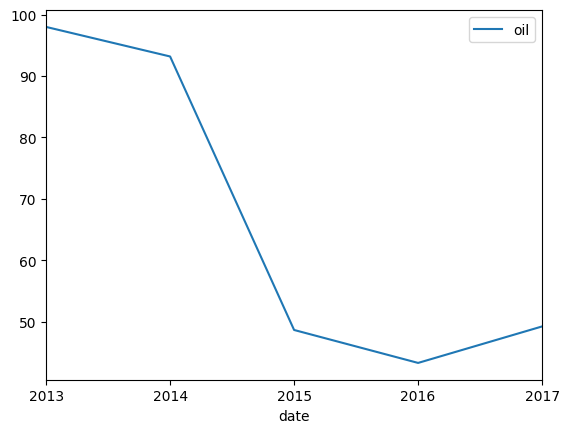

In [127]:
oil.resample("YE").mean().plot(legend = True);

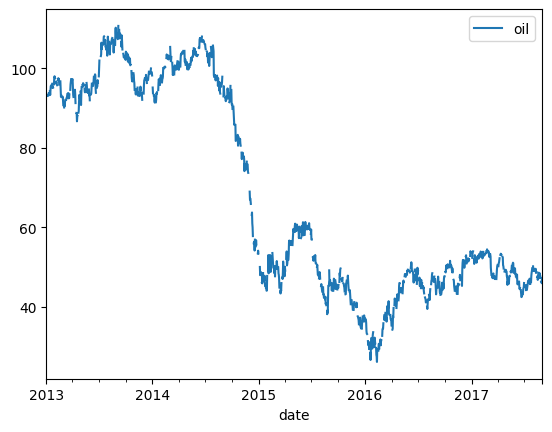

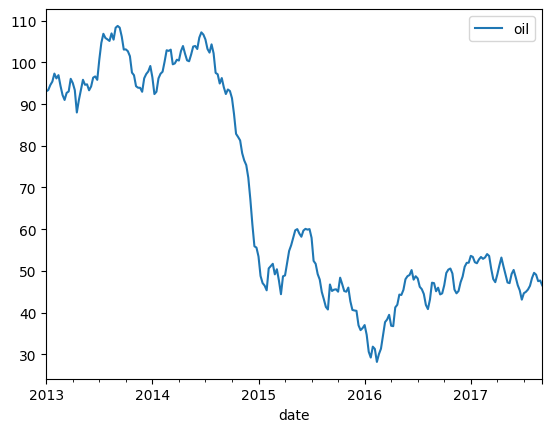

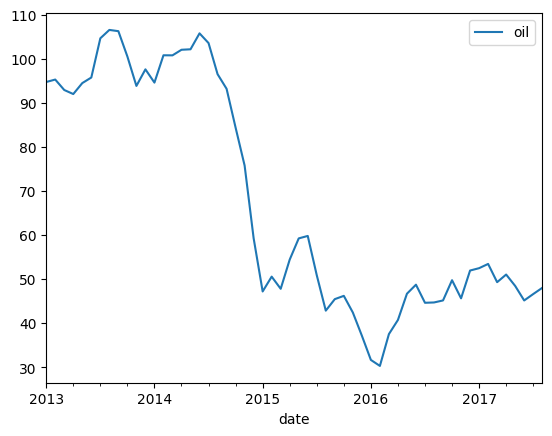

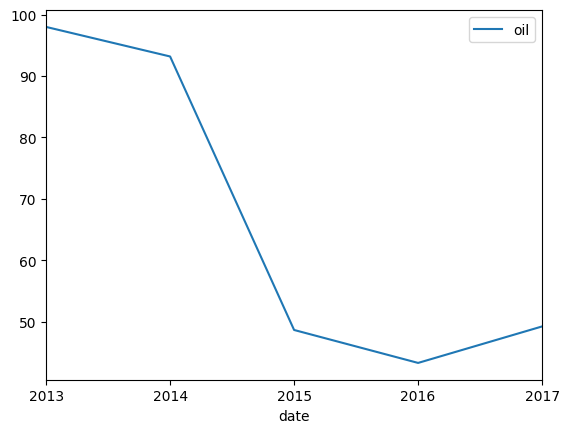

In [132]:
# With a loop
for period in ["D", "W", "ME", "YE"]:
    oil.resample(period).mean().plot()

<Axes: xlabel='date'>

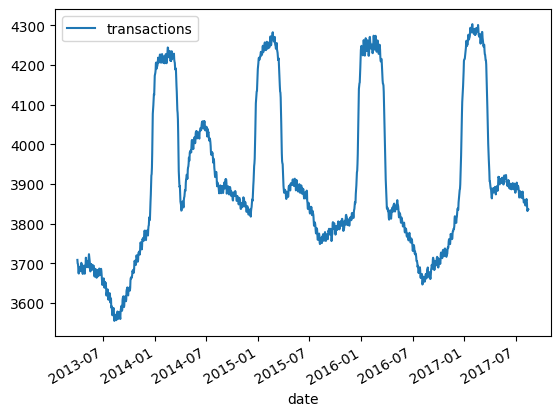

In [149]:
# Can you plot the 90-day moving average for transactions from store 47?
(transactions.loc[trans_df["store_nbr"] == 47, ["date", "transactions"]]
 .set_index("date").
 rolling(90).
 mean().
 plot()
 );